In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from os import path
from astropy.io import fits

from spectrum import Spectrum, FitsSpectrum
from common import list_files, list_directories, tqdm
import functions as func

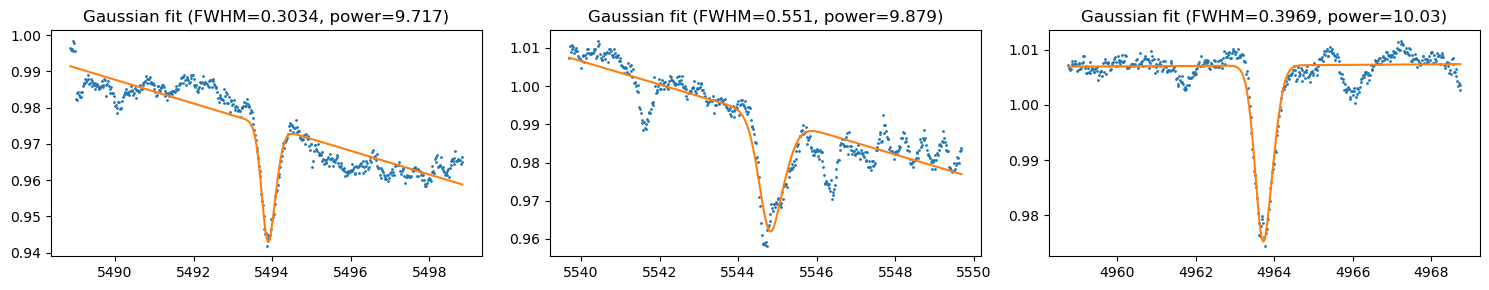

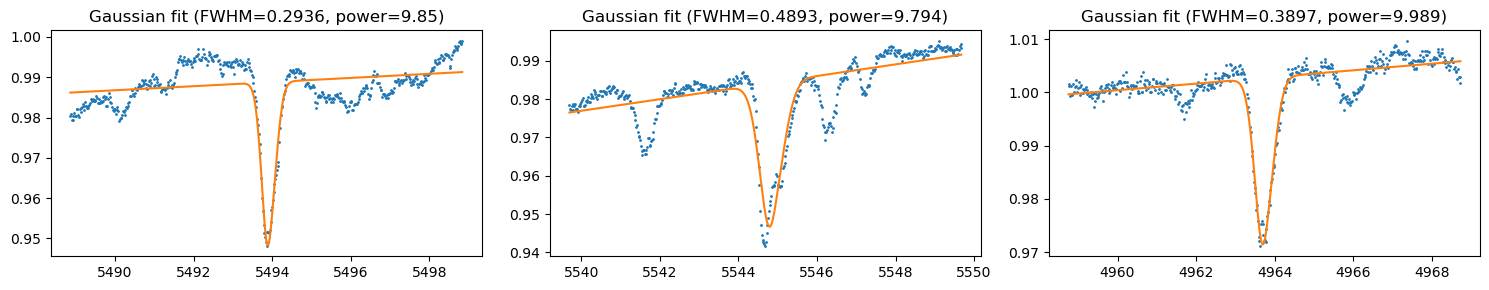

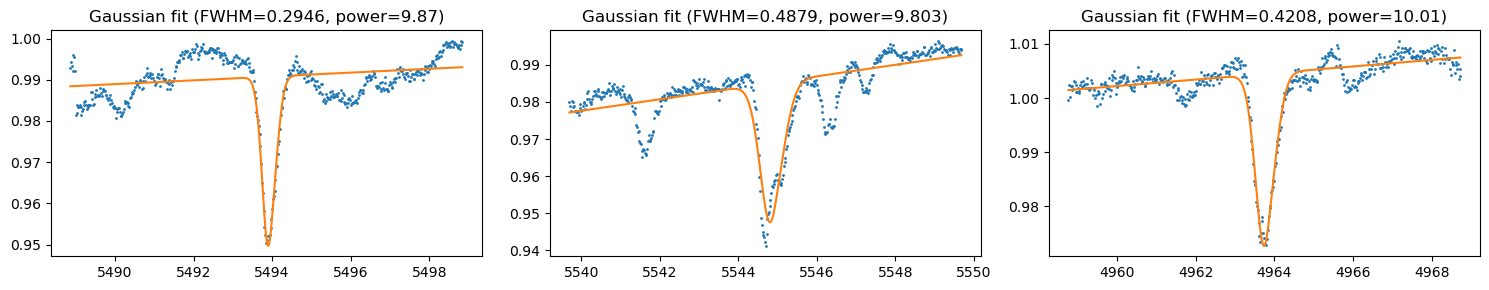

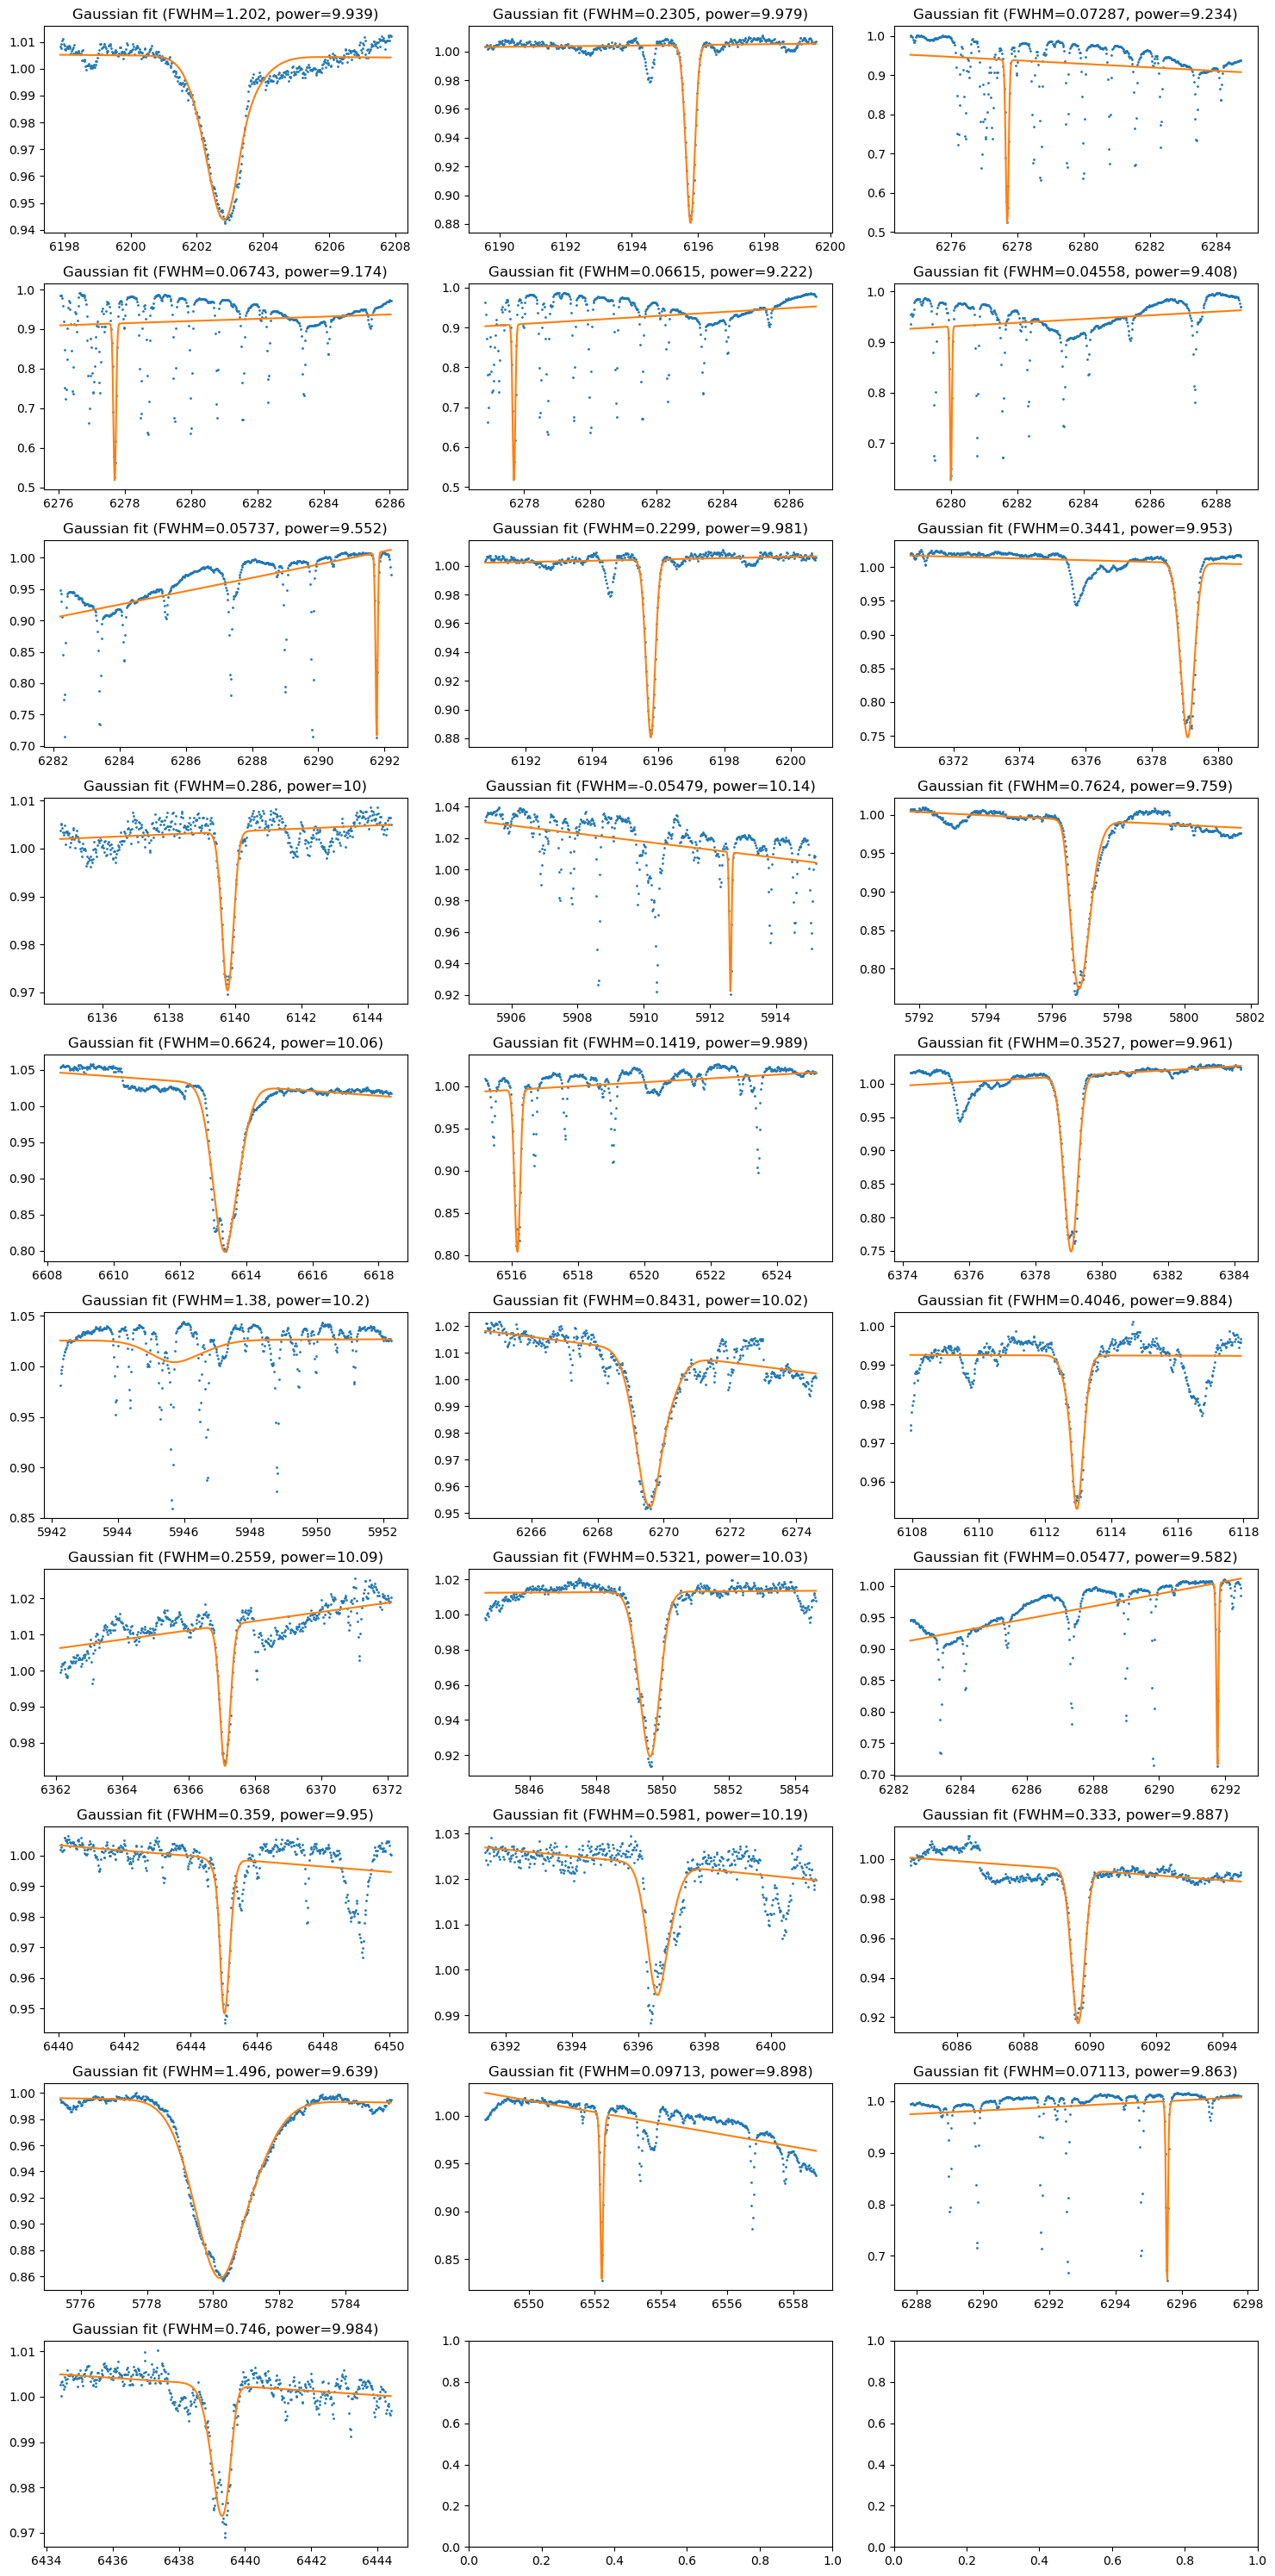

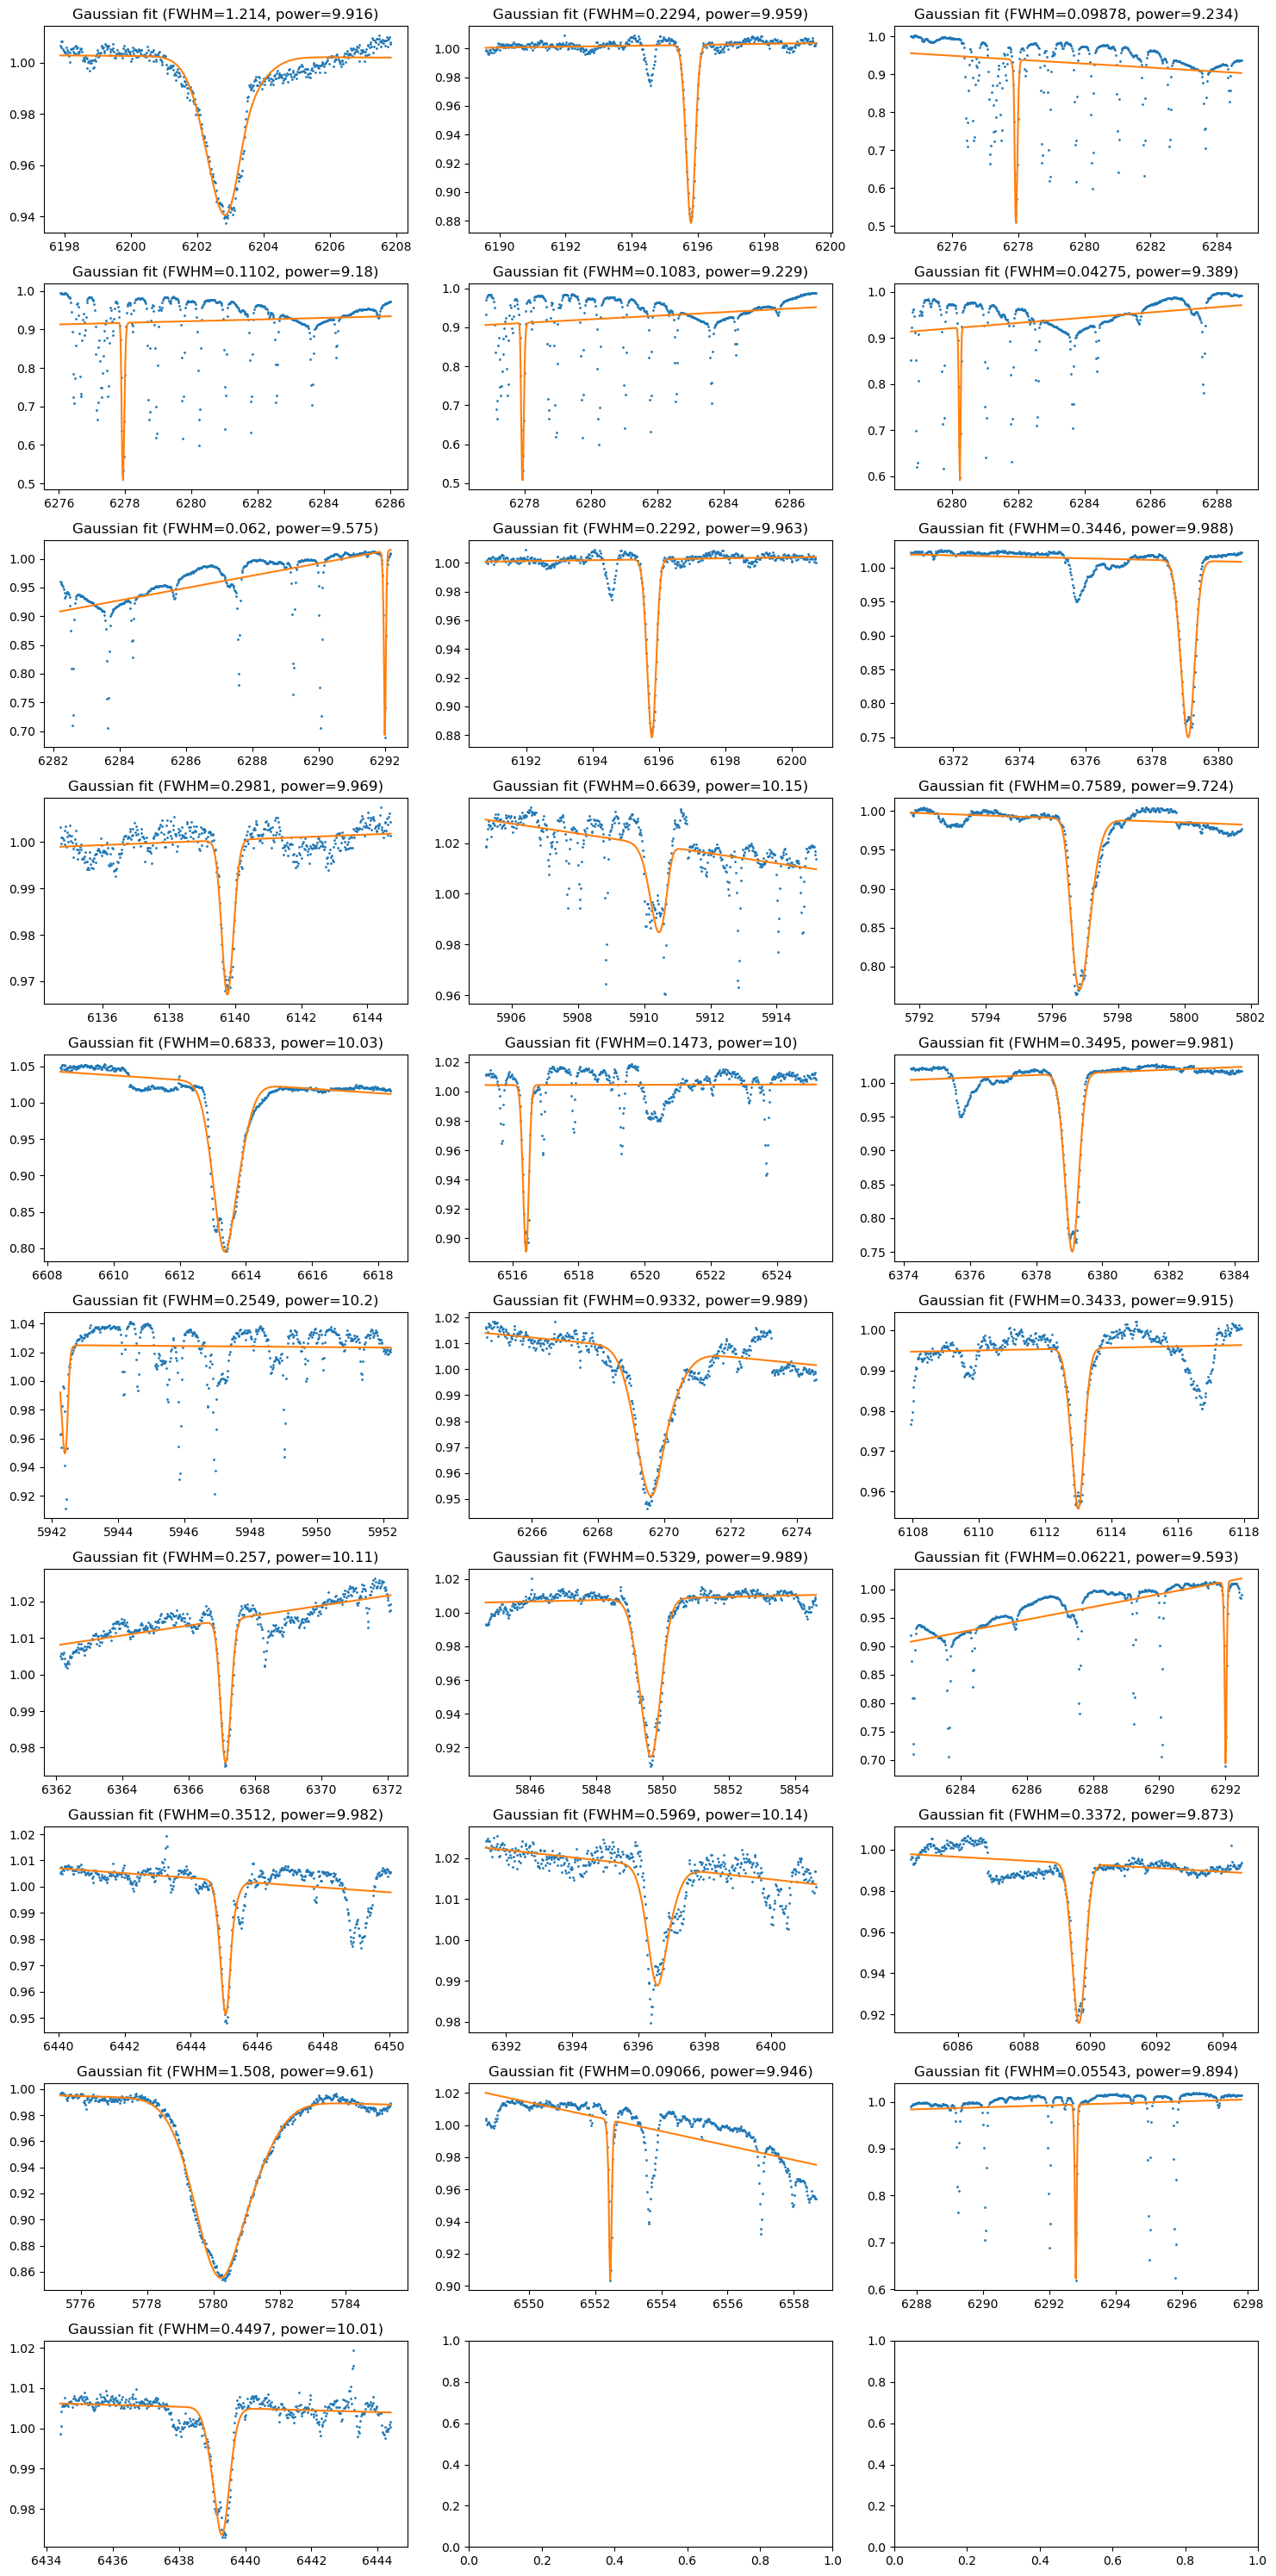

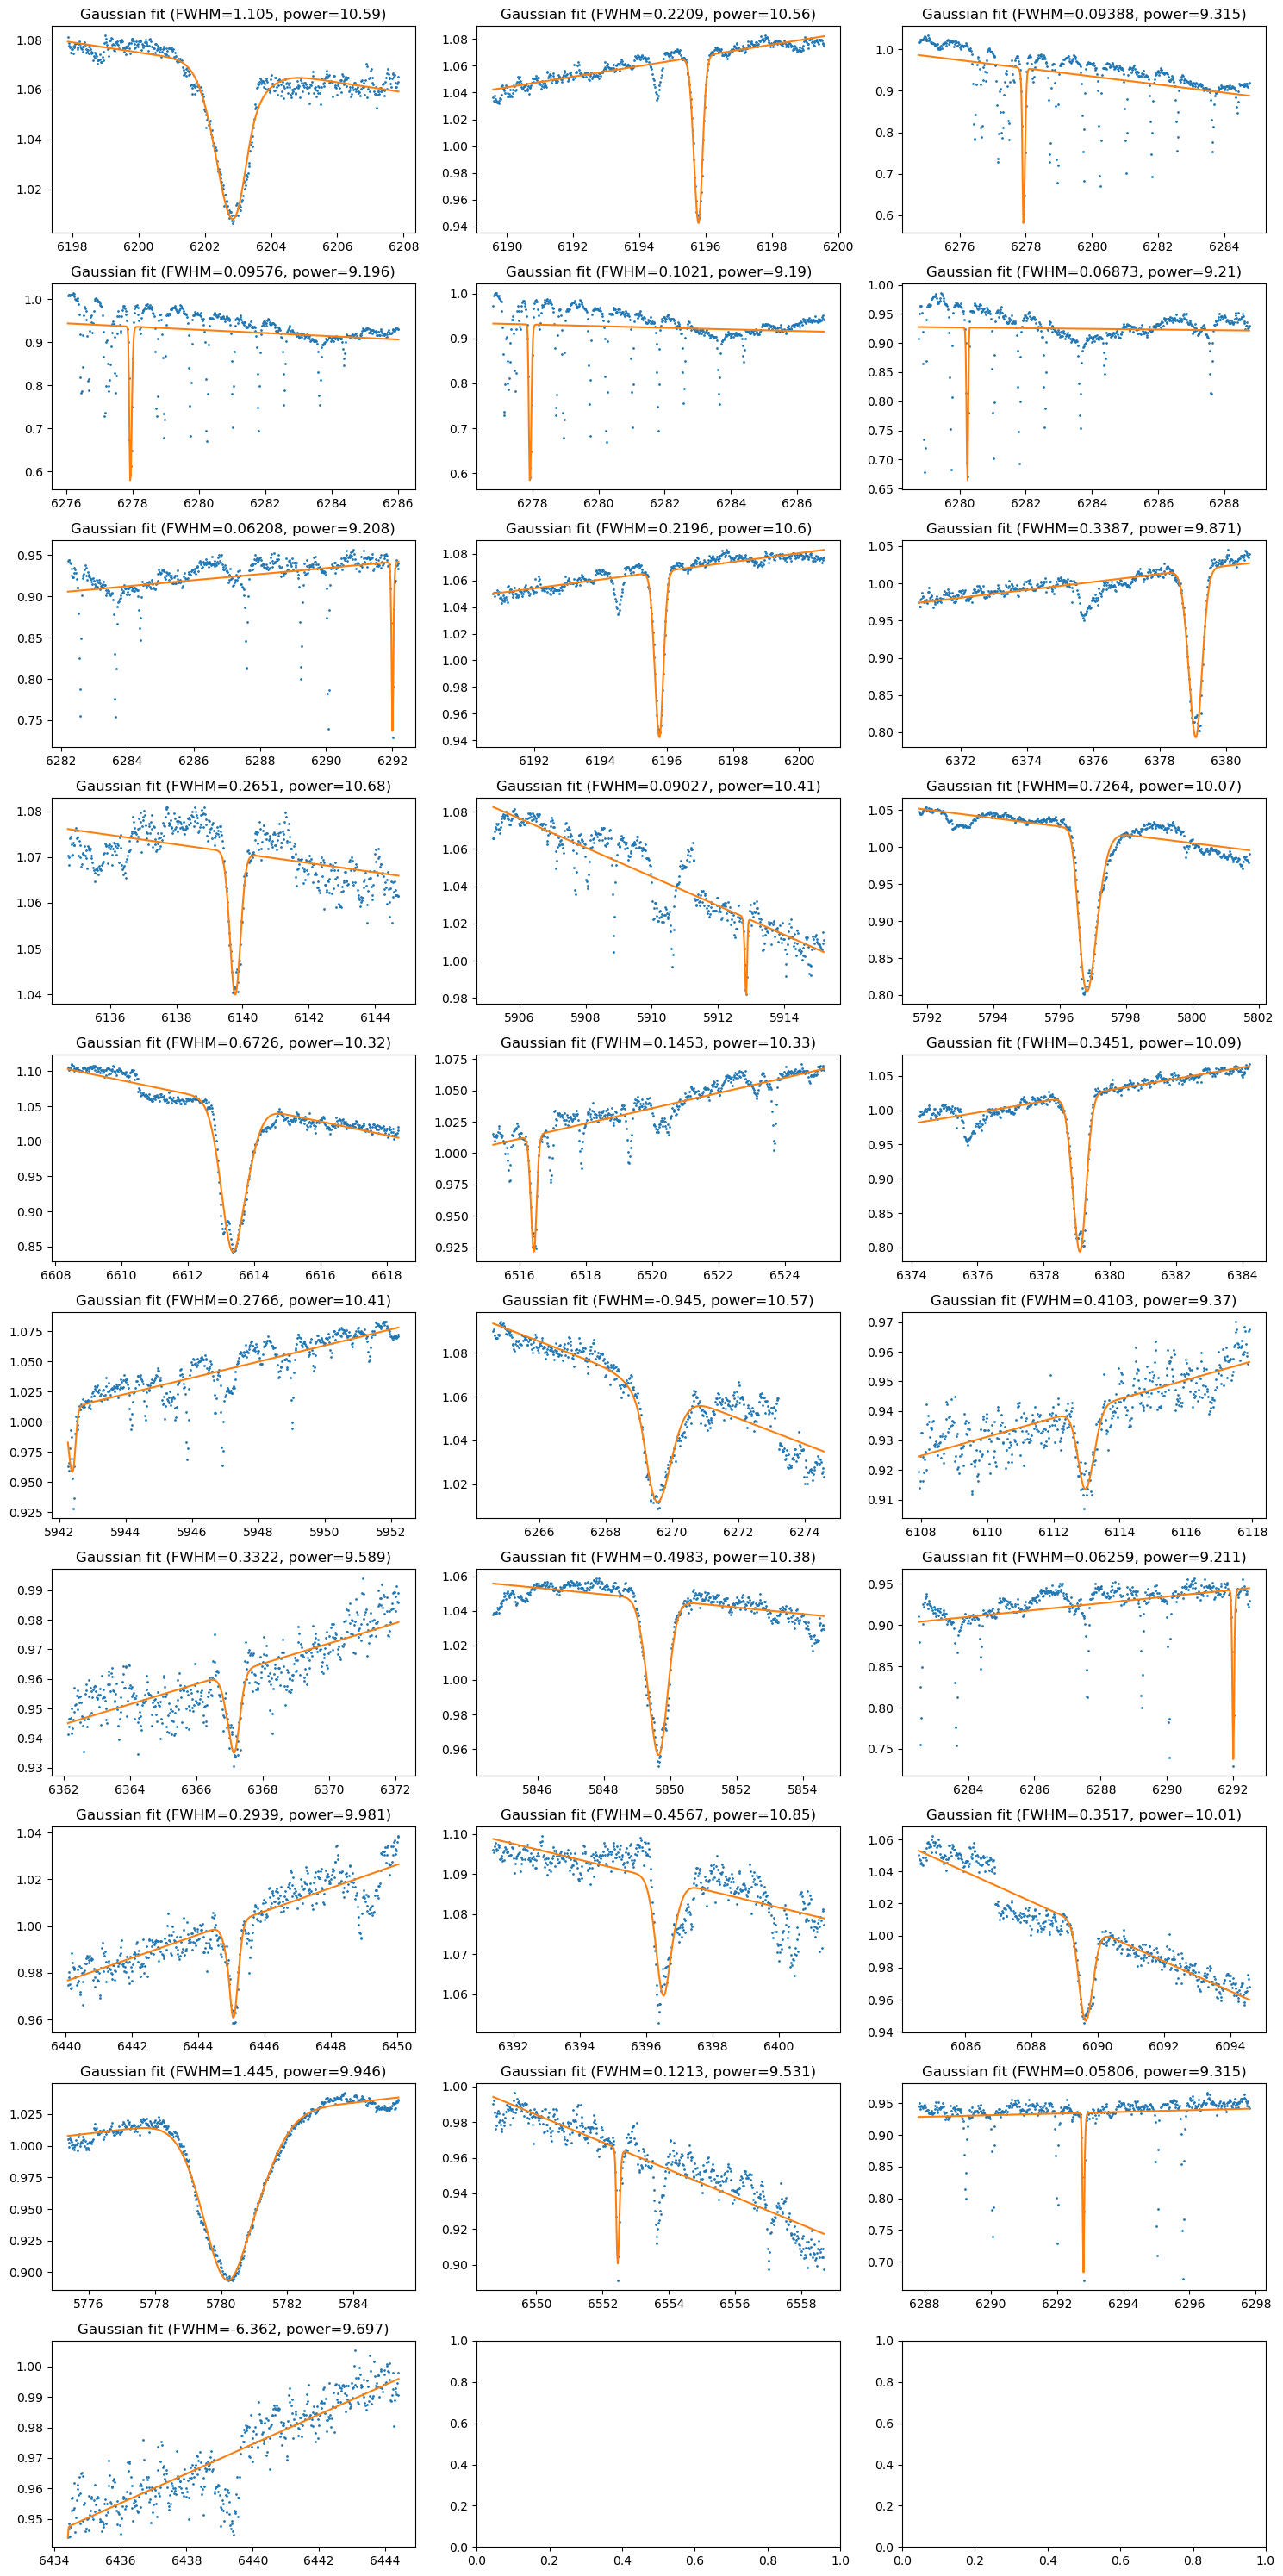

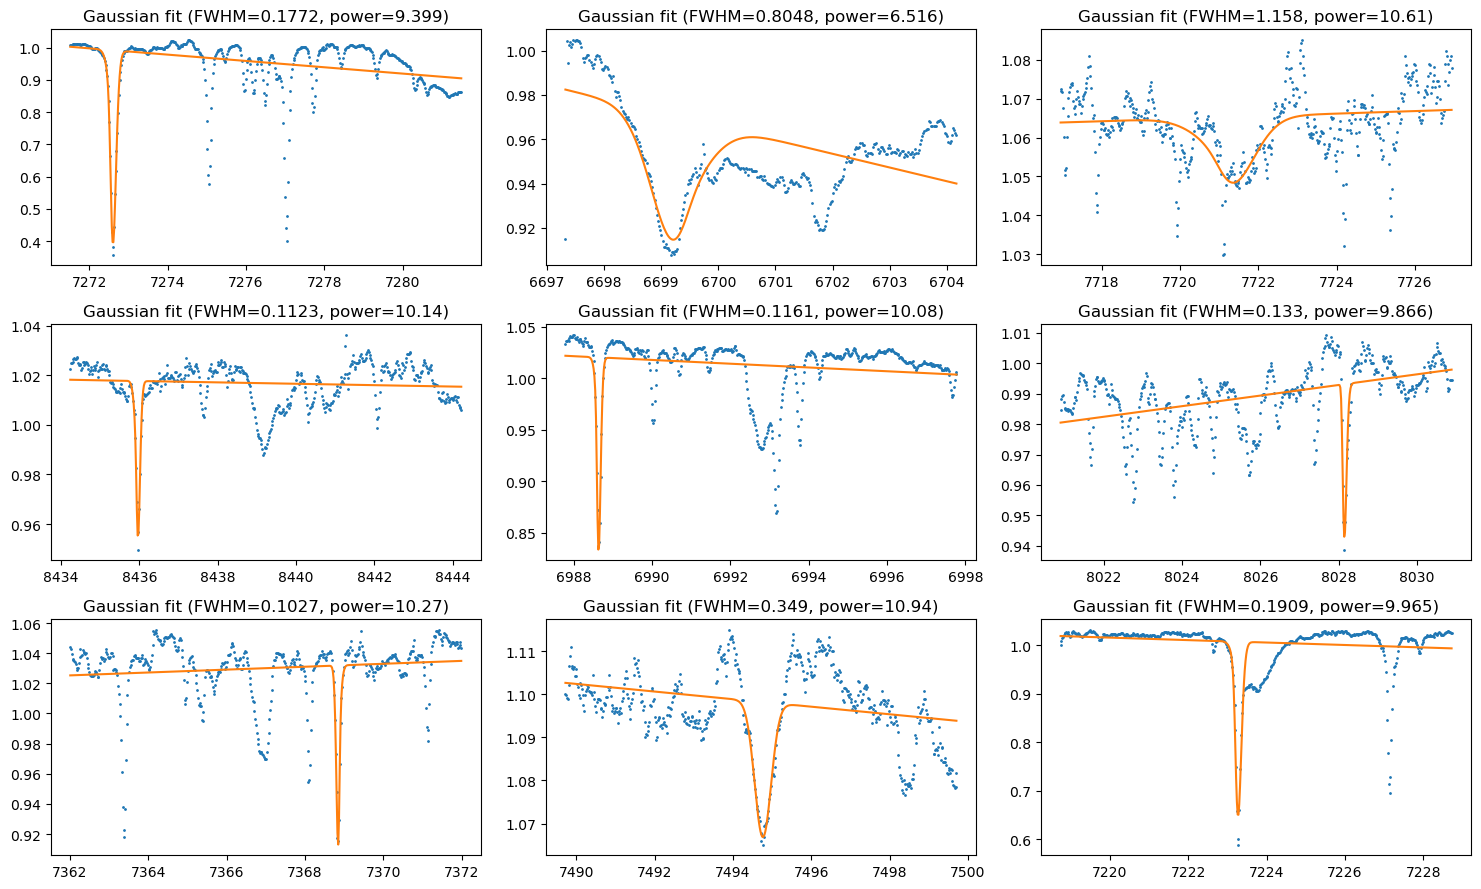

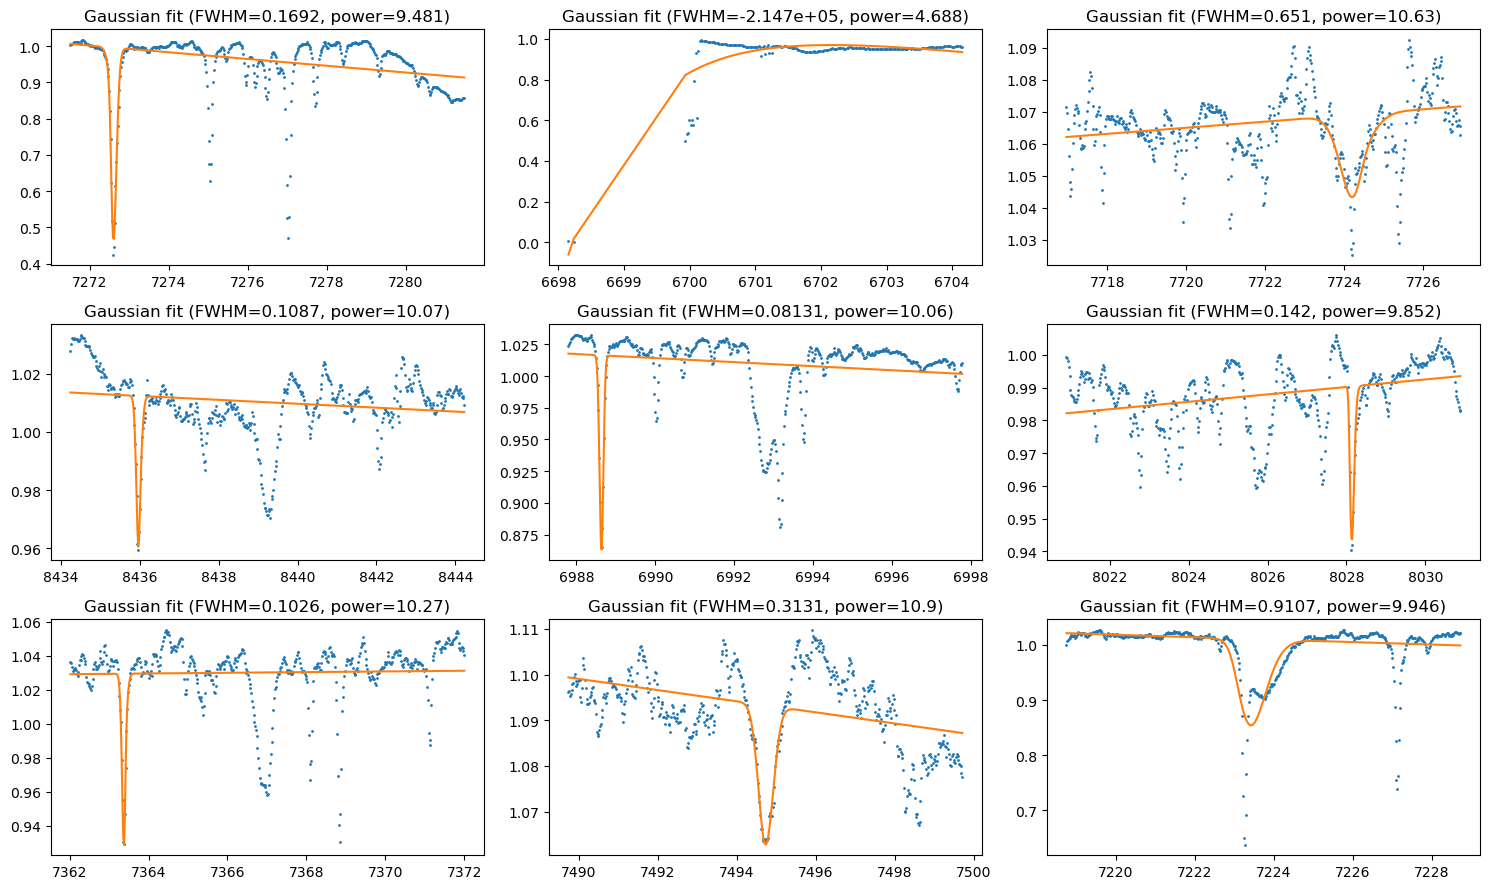

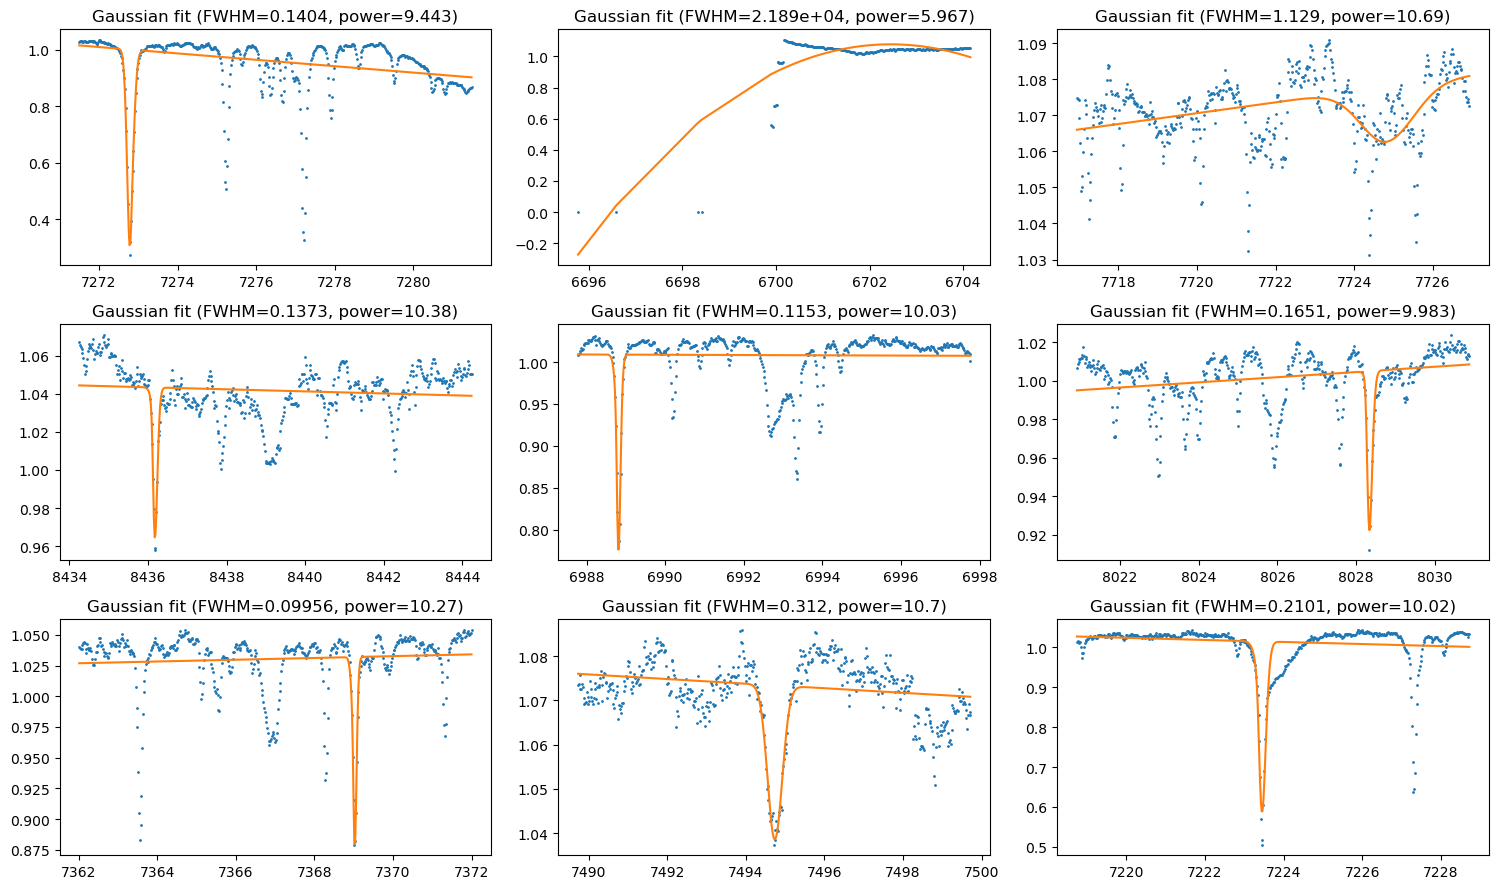

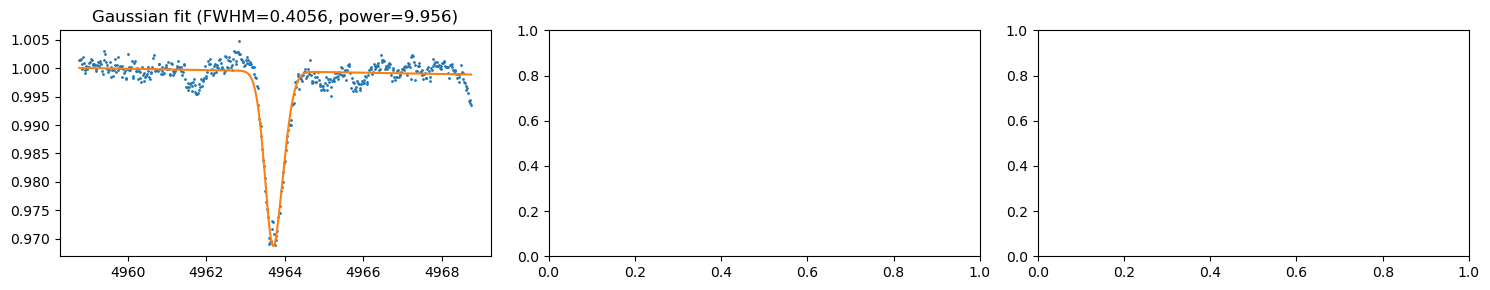

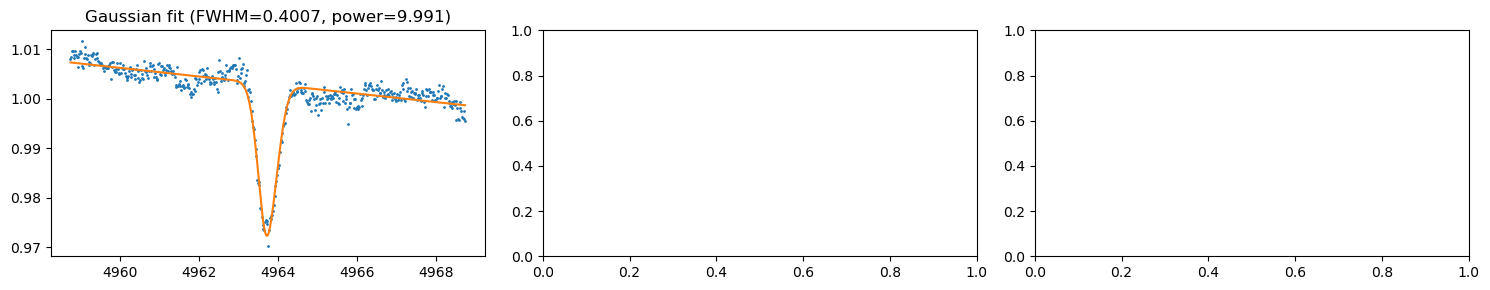

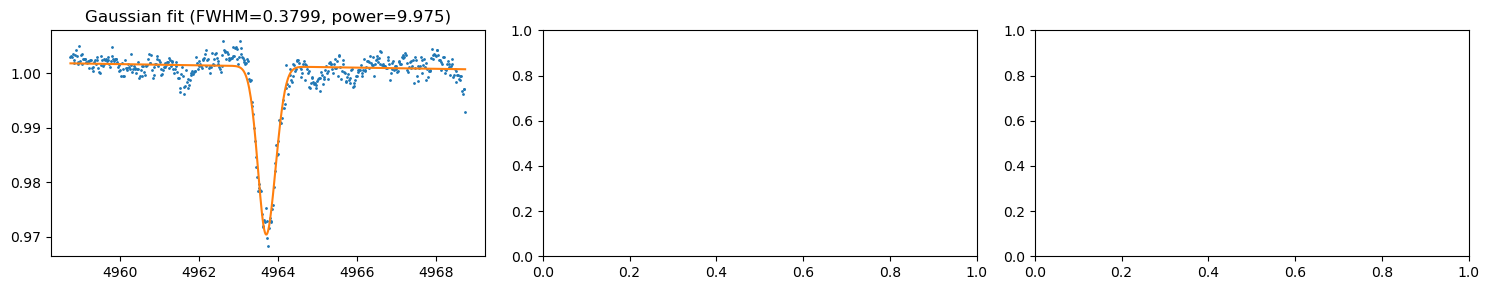

In [ ]:
def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

wavelength_dibs, spectrum_dibs=func.fileloader('data/dibs')
dib_centra_list=[5780,5797,6196,6379,6613,7224]
dib_wavelengths,dib_spectra,dib_locs=func.dib_finder(wavelength_dibs,spectrum_dibs,locs=dib_centra_list,wave_range=3,threshold=0.03)

hd185859 = load_target('data/fits/HD185859')
dib_spectra = []

def fit_dibs(dib_wvls, dib_spectra, model = func.skewed_gauss):
    assert len(dib_wvls) == len(dib_spectra), f'len(dib_wvls)={len(dib_wvls)} and len(dib_spectra)={len(dib_spectra)}, but they must have the same length'

    bounds_list = []
    p0_list = []
    centra_list = []

    for dib_wvl, dib_spectrum in zip(dib_wvls, dib_spectra):
        dib_center = func.min_finder(dib_wvl, dib_spectrum)

        centra_list.append(dib_center)
        p0_list.append([dib_center,0.1,0.10,2])
        bounds_list.append(np.array((
            [dib_center-0.5,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf],
            [dib_center+0.5, np.inf, np.inf, np.inf, np.inf, np.inf]
        )))

    return func.fitter_plotter(dib_wvls, dib_spectra, model, centra_list, p0_list=p0_list, bounds_list=bounds_list)

for subspectrum in hd185859:
    subspectrum.remove_outliers()
    subspectrum.normalize(max_degree=10)
    subspectrum.correct_shift()

    dib_wavelengths, dib_fluxes, centra_list = func.dib_finder(
        subspectrum.wavelength, subspectrum.flux,
        locs=dib_locs, wave_range=5, index_search=True, ref_wavelengths=wavelength_dibs
    )

    params, predictions = fit_dibs(dib_wavelengths, dib_fluxes)
    fwhm_list = [func.FWHM(params[1]) for params in params]
    power_list = [np.trapezoid(pred, wvl) for pred, wvl in zip(predictions, dib_wavelengths)]

    if len(dib_wavelengths) > 0:
        ncols = 3
        nrows = int(np.ceil(len(dib_wavelengths) / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

        for wvl, flux, fit, ax, fwhm, power in zip(dib_wavelengths, dib_fluxes, predictions, axes.flatten(), fwhm_list, power_list):
            ax.plot(wvl, flux, '.', ms=2)
            ax.plot(wvl, fit)
            ax.set_title(f'Gaussian fit (FWHM={fwhm:.4g}, power={power:.4g})')

        fig.tight_layout()
    